In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from experiments2.auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'error_gradation_images'

In [17]:
data = pd.read_csv("../../datasets/credit.csv")
#data = data.reset_index().drop(columns=["index"])
n_features = data.shape[1]-1
n = data.shape[0]
data["default"] = (data["NumberOfTimes90DaysLate"] > 0).astype(int)
data.drop(columns=["NumberOfTimes90DaysLate", 'NumberOfTime60-89DaysPastDueNotWorse'], inplace=True)
n_features = data.shape[1]-1
n = data.shape[0]
data.rename(columns={feat: "".join(feat.split("-")) for feat in data.columns}, inplace=True)
target = "default"
features = data.columns.difference([target]).tolist()

data.head(10)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,SeriousDlqin2yrs,default
0,0.006999,38,0,0.302150,5440.0,4,1,3,0,0
1,0.704592,63,0,0.471441,8000.0,9,1,0,0,0
2,0.063113,57,0,0.068586,5000.0,17,0,0,0,0
3,0.368397,68,0,0.296273,6250.0,16,2,0,0,0
4,1.000000,34,1,0.000000,3500.0,0,0,1,0,0
5,0.051799,63,0,0.770687,4700.0,16,1,1,0,0
6,0.648733,40,1,0.402060,6600.0,10,2,3,0,0
7,0.767270,33,0,0.338390,5800.0,10,0,3,0,0
8,0.190111,27,0,0.164605,3960.0,6,0,1,0,0
9,0.139989,65,1,0.258397,6400.0,6,1,0,0,0


In [18]:
data.shape

(16714, 10)

In [19]:
features

['DebtRatio',
 'MonthlyIncome',
 'NumberOfDependents',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTime3059DaysPastDueNotWorse',
 'NumberRealEstateLoansOrLines',
 'RevolvingUtilizationOfUnsecuredLines',
 'SeriousDlqin2yrs',
 'age']

In [20]:
def entropy(a):
    vc = a.value_counts()
    vc/=vc.sum()
    return -(vc*np.log(vc)).sum()

In [21]:
def discretize(data, variables, icat, icont, contdiscstrategy="kmeans", n_bins=3):
    transformers_data = dict()
    
    if icat is None: # в датасете только непрерывные фичи (и предиктор)
        pipeline = make_pipeline(
            KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy), 
            FunctionTransformer(lambda x: x.astype("int")))
    elif icont is None: # в датасете только категориальные фичи (и предиктор)
        pipeline = make_pipeline(
            OrdinalEncoder(categories="auto"), 
            FunctionTransformer(lambda x: x.astype("int")))
    else:
        pipeline = make_pipeline(make_union(
        make_pipeline(FunctionTransformer(lambda x: x.iloc[:, icat]), OrdinalEncoder(categories="auto")),
        make_pipeline(FunctionTransformer(lambda x: x.loc[:, icont]), KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy))
    ),
        FunctionTransformer(lambda x: x.astype("int")))
    
    
    pipeline.fit(data)
    encoded_data = pd.DataFrame(pipeline.transform(data), columns=data.columns if icat is None or icont is None\
                                                                                        else data.columns[icat+icont])
    encoded_data = encoded_data[variables] # в общем случае пайплайн переставляет признаки, возвращаем их на их места здесь

    for feat in encoded_data.columns:
        if entropy(encoded_data[feat]) < 0.5:
            print(f"Warning: feature {feat} has practically degenerate states and low entropy")
    transformers_data["transformer"] = pipeline
    
    if icat is None:
        transformers_data["cont_features"]       = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cont_features_edges"] = pipeline.steps[0][1].bin_edges_
        
    elif icont is None:
        transformers_data["cat_features"]            = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].categories_
        
    else:
        transformers_data["cont_features"]           = list(pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].get_feature_names_out())
        transformers_data["cont_features_edges"]     = pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].bin_edges_
        transformers_data["cat_features"]            = list(pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_
    
    #kmeanspipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_[0]
    return encoded_data, transformers_data

#disc_data, pipeline_data = discretize(data, variables, icat=None, icont=[0, 1])


In [22]:
data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))

In [23]:
for col in data_disc.columns:
    print(data_disc[col].value_counts())

DebtRatio
0    16705
1        7
2        2
Name: count, dtype: int64
MonthlyIncome
0    13557
1     3122
2       35
Name: count, dtype: int64
NumberOfDependents
0    12026
1     4064
2      624
Name: count, dtype: int64
NumberOfOpenCreditLinesAndLoans
0    9438
1    5945
2    1331
Name: count, dtype: int64
NumberOfTime3059DaysPastDueNotWorse
0    16625
2       86
1        3
Name: count, dtype: int64
NumberRealEstateLoansOrLines
0    15392
1     1259
2       63
Name: count, dtype: int64
RevolvingUtilizationOfUnsecuredLines
0    16702
1       11
2        1
Name: count, dtype: int64
SeriousDlqin2yrs
0    8357
1    8357
Name: count, dtype: int64
age
1    6925
0    6326
2    3463
Name: count, dtype: int64


In [24]:
model = GradientBoostingClassifier(n_estimators=50)
#model = LogisticRegression()
model.fit(data[features], data[target])

GradientBoostingClassifier(n_estimators=50)

In [35]:
data_errors = data.copy(deep=True)
probs = model.predict_proba(data[features])[:, 1]
data_errors["inconf_error"] = (1-probs)*data[target]+(probs)*(1-data[target]) #inconfidence measure: the larger the worser inconfidence

data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,SeriousDlqin2yrs,inconf_error
0,0.006999,38,0,0.302150,5440.0,4,1,3,0,0.025756
1,0.704592,63,0,0.471441,8000.0,9,1,0,0,0.023291
2,0.063113,57,0,0.068586,5000.0,17,0,0,0,0.022476
3,0.368397,68,0,0.296273,6250.0,16,2,0,0,0.019876
4,1.000000,34,1,0.000000,3500.0,0,0,1,0,0.541359


In [36]:
disc_data, pipeline_data = discretize(data_errors, features+["inconf_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,DebtRatio,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberOfTime3059DaysPastDueNotWorse,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,SeriousDlqin2yrs,age,inconf_error
0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,2,0
2,0,0,0,2,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,2,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
16709,0,0,1,0,0,0,0,1,1,1
16710,0,0,0,1,0,1,0,1,0,1
16711,0,0,0,0,0,0,0,1,0,1
16712,0,0,2,0,0,0,0,1,1,1


In [27]:
pipeline_data['cont_features']

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime3059DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines',
 'NumberOfDependents',
 'SeriousDlqin2yrs',
 'inconf_error']

In [37]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
dicval

{'RevolvingUtilizationOfUnsecuredLines': [0.0,
  0.011572803900000001,
  0.05085956640000001,
  0.130933657,
  0.2633955044,
  0.4430804445,
  0.6500328584,
  0.8521191548999999,
  0.9825454540000002,
  0.9999999,
  22000.0],
 'age': [21.0, 31.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 61.0, 67.0, 101.0],
 'NumberOfTime3059DaysPastDueNotWorse': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  2.0,
  98.0],
 'DebtRatio': [0.0,
  0.0349890735,
  0.119376595,
  0.1898881473,
  0.25543168280000006,
  0.3222994135,
  0.39360053880000007,
  0.47915565819999995,
  0.6041003132,
  0.8550448880000001,
  61106.5],
 'MonthlyIncome': [0.0,
  2000.0,
  2800.0,
  3500.0,
  4200.0,
  5000.0,
  5833.0,
  6932.0999999999985,
  8400.0,
  10959.0,
  250000.0],
 'NumberOfOpenCreditLinesAndLoans': [0.0,
  2.0,
  4.0,
  5.0,
  6.0,
  8.0,
  9.0,
  10.0,
  12.0,
  16.0,
  57.0],
 'NumberRealEstateLoansOrLines': [0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  2.0,
  29.0],
 'NumberO

In [38]:
v = pipeline_data["cont_features_edges"]
for i in [3, 4, 2, 6, 0, 9]:
    v[i] = [v[i][0], dicval[pipeline_data["cont_features"][i]][3], dicval[pipeline_data["cont_features"][i]][7], v[i][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

In [39]:
data__ = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=data_errors.columns)
data__

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,SeriousDlqin2yrs,inconf_error
0,0,0,1,1,1,0,2,1,0,0
1,1,2,1,1,2,1,2,0,0,0
2,0,1,1,0,1,2,1,0,0,0
3,1,2,1,1,1,1,2,0,0,0
4,2,0,2,0,1,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...
16709,2,1,1,2,0,0,1,1,1,2
16710,2,0,2,2,2,1,2,0,1,2
16711,2,0,2,0,0,0,1,0,1,2
16712,2,1,1,0,1,0,1,2,1,2


In [40]:
for col in data_disc.columns:
    print(data__[col].value_counts())

DebtRatio
1    6686
0    5014
2    5014
Name: count, dtype: int64
MonthlyIncome
1    6776
2    5014
0    4924
Name: count, dtype: int64
NumberOfDependents
0    12026
1     4064
2      624
Name: count, dtype: int64
NumberOfOpenCreditLinesAndLoans
0    9438
1    5945
2    1331
Name: count, dtype: int64
NumberOfTime3059DaysPastDueNotWorse
1    11346
2     5368
Name: count, dtype: int64
NumberRealEstateLoansOrLines
2    10092
1     6622
Name: count, dtype: int64
RevolvingUtilizationOfUnsecuredLines
1    6686
0    5014
2    5014
Name: count, dtype: int64
SeriousDlqin2yrs
0    8357
1    8357
Name: count, dtype: int64
age
1    6925
0    6326
2    3463
Name: count, dtype: int64


In [41]:
current_error = data_errors["inconf_error"].sum()/n
current_error

0.2146563619031136

In [43]:
disc_data = data__

In [44]:
disc_data["inconf_error"].value_counts()

inconf_error
1    6696
2    5014
0    5004
Name: count, dtype: int64

In [45]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore

def collect_all_cpds(bn_info, distributions, n_states_map):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, n_states_map[feat], [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            #cpd_list = [probs for i, probs in distributions[feat]["cprob"].items() if i[0]!="["]
            #print(cpd_list)
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            #print(feat, row["parents"])
            #print(cpd_list)
            cpd = TabularCPD(feat, n_states_map[feat], cpd_list, evidence=row["parents"], evidence_card=[n_states_map[p] for p in row["parents"]])
            cpds.append(cpd)
    return cpds



In [46]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'RevolvingUtilizationOfUnsecuredLines': 3,
 'age': 3,
 'NumberOfTime3059DaysPastDueNotWorse': 2,
 'DebtRatio': 3,
 'MonthlyIncome': 3,
 'NumberOfOpenCreditLinesAndLoans': 3,
 'NumberRealEstateLoansOrLines': 2,
 'NumberOfDependents': 3,
 'SeriousDlqin2yrs': 2,
 'inconf_error': 3}

In [47]:
#STORAGE = "C://Users/Дима/PycharmProjects/GIEBN/experiments/pgmpy_yodo_exps/bn_structures"

bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("inconf_error", x) for x in features]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)

In [48]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [49]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,NumberOfOpenCreditLinesAndLoans,Discrete,disc,[],[]
1,SeriousDlqin2yrs,Discrete,disc,[],[]
2,NumberOfTime3059DaysPastDueNotWorse,Discrete,disc,[SeriousDlqin2yrs],[disc]
3,RevolvingUtilizationOfUnsecuredLines,Discrete,disc,"[NumberOfTime3059DaysPastDueNotWorse, NumberOf...","[disc, disc, disc]"
4,inconf_error,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberO...","[disc, disc, disc, disc]"
5,NumberRealEstateLoansOrLines,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberO...","[disc, disc]"
6,DebtRatio,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberO...","[disc, disc, disc]"
7,MonthlyIncome,Discrete,disc,"[DebtRatio, NumberOfOpenCreditLinesAndLoans, N...","[disc, disc, disc]"
8,age,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, Monthly...","[disc, disc, disc]"
9,NumberOfDependents,Discrete,disc,"[age, MonthlyIncome]","[disc, disc]"


In [50]:
bn.nodes

[NumberOfOpenCreditLinesAndLoans,
 SeriousDlqin2yrs,
 NumberOfTime3059DaysPastDueNotWorse,
 RevolvingUtilizationOfUnsecuredLines,
 inconf_error,
 NumberRealEstateLoansOrLines,
 DebtRatio,
 MonthlyIncome,
 age,
 NumberOfDependents]

In [51]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [56]:
bn.distributions

{'HouseAge': {'cprob': [0.34578850441019676,
   0.414655423088107,
   0.23955607250169622],
  'vals': ['0', '1', '2']},
 'Longitude': {'cprob': {"['1']": [0.337190275829827,
    0.511921458625526,
    0.15088826554464704],
   "['2']": [0.4466922921302853, 0.48270281205745497, 0.07060489581225976],
   "['0']": [0.416958654519972, 0.28100911002102313, 0.3020322354590049]},
  'vals': ['0', '1', '2']},
 'AveRooms': {'cprob': {"['1', '0']": [0.1975736568457539,
    0.4658578856152513,
    0.3365684575389948],
   "['1', '2']": [0.2974438419829589, 0.4058869093725794, 0.29666924864446165],
   "['1', '1']": [0.38995433789954337,
    0.3865296803652968,
    0.22351598173515982],
   "['2', '0']": [0.32971014492753625, 0.4791666666666667, 0.1911231884057971],
   "['2', '2']": [0.41260744985673353,
    0.44412607449856734,
    0.14326647564469913],
   "['2', '1']": [0.44970662196144173,
    0.39522212908633697,
    0.1550712489522213],
   "['0', '0']": [0.17411764705882352,
    0.40436974789915964

In [52]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

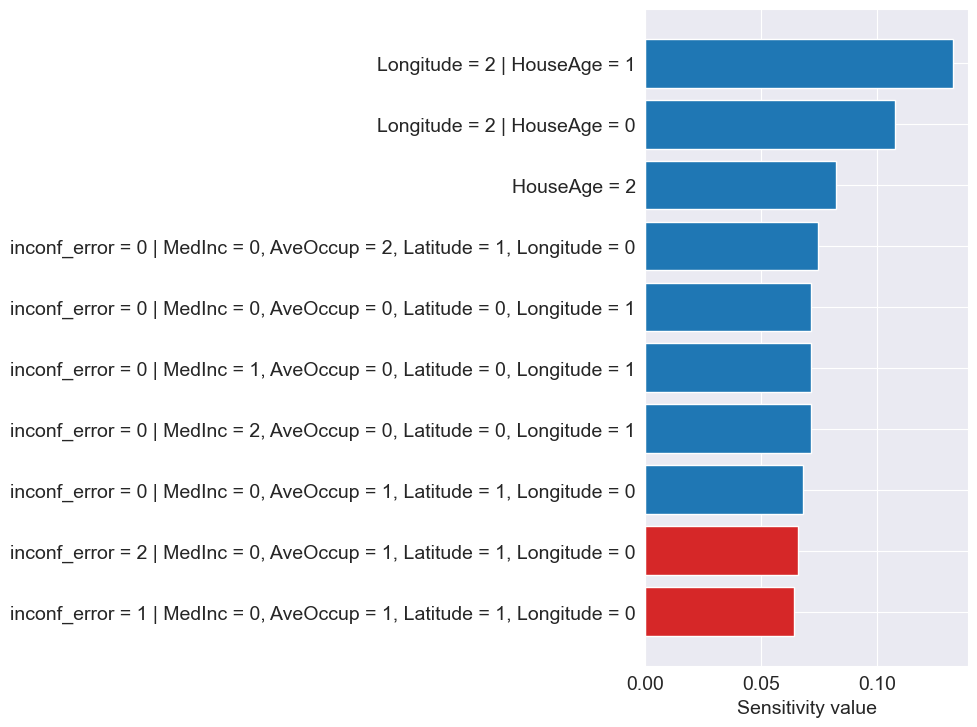

In [58]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 0}, nbars=10)

<Figure size 640x480 with 0 Axes>

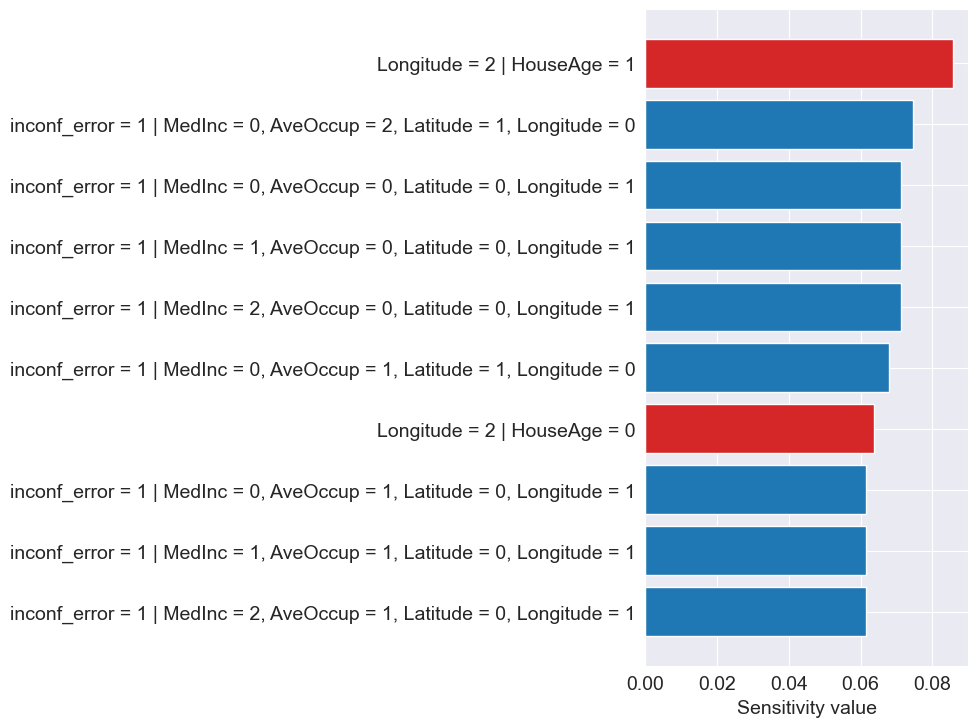

In [59]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 1}, nbars=10)

<Figure size 640x480 with 0 Axes>

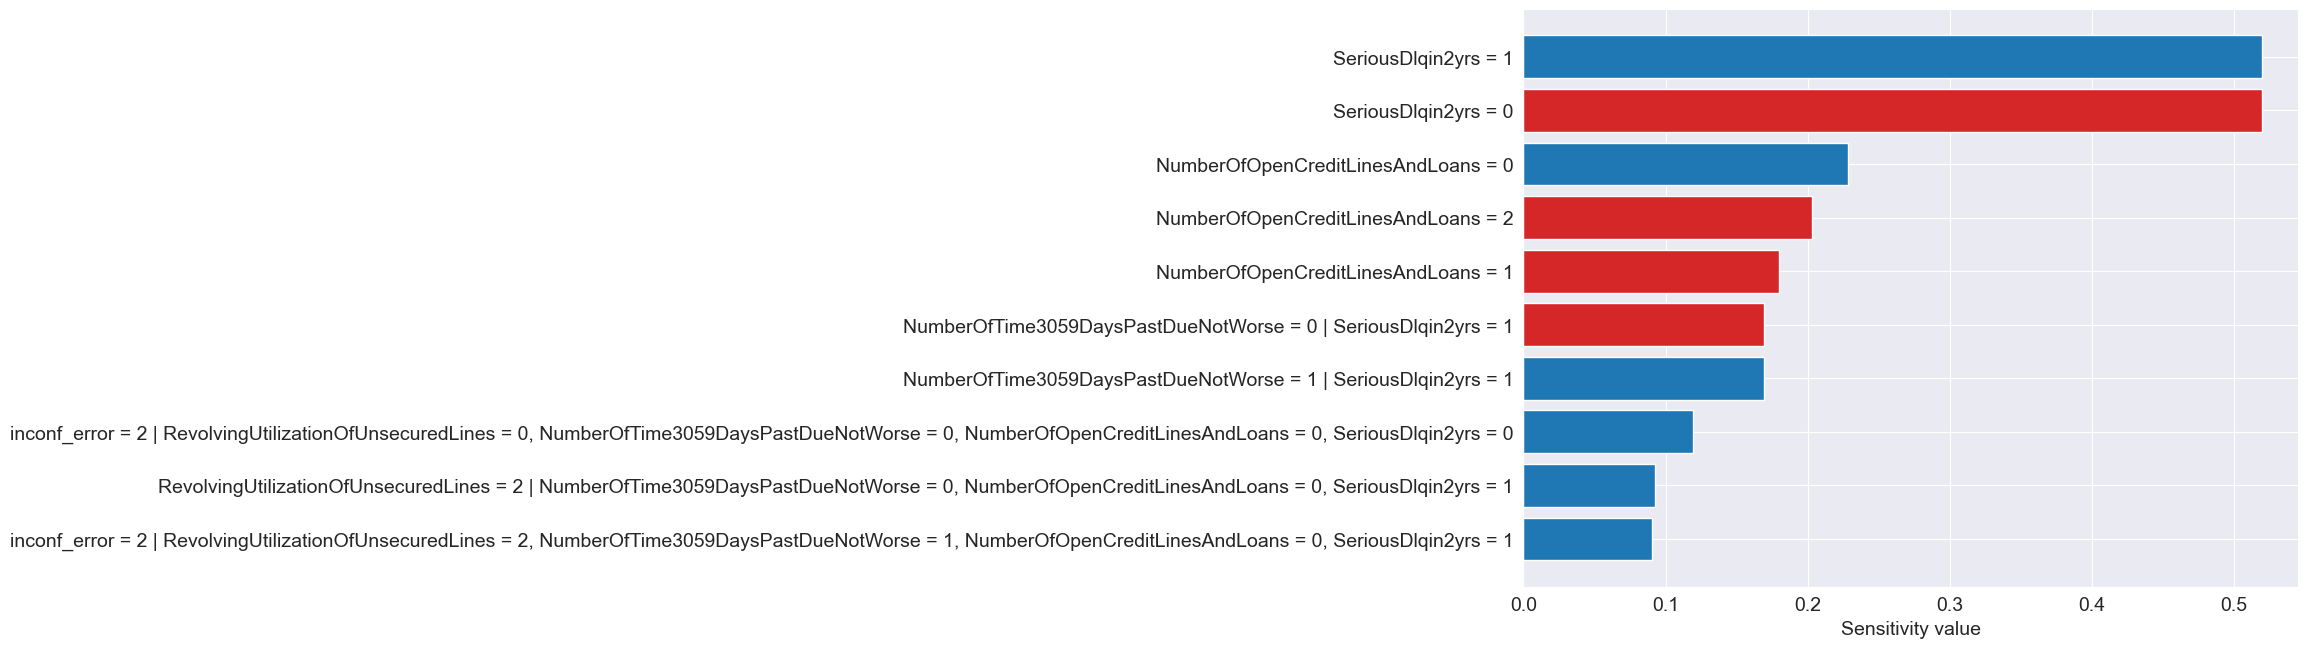

In [53]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии высокого УФ-индекса (здесь 1 маскимальный) и среднего давления

In [54]:
data__['SeriousDlqin2yrs'].value_counts()

SeriousDlqin2yrs
0    8357
1    8357
Name: count, dtype: int64

In [55]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score

In [56]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

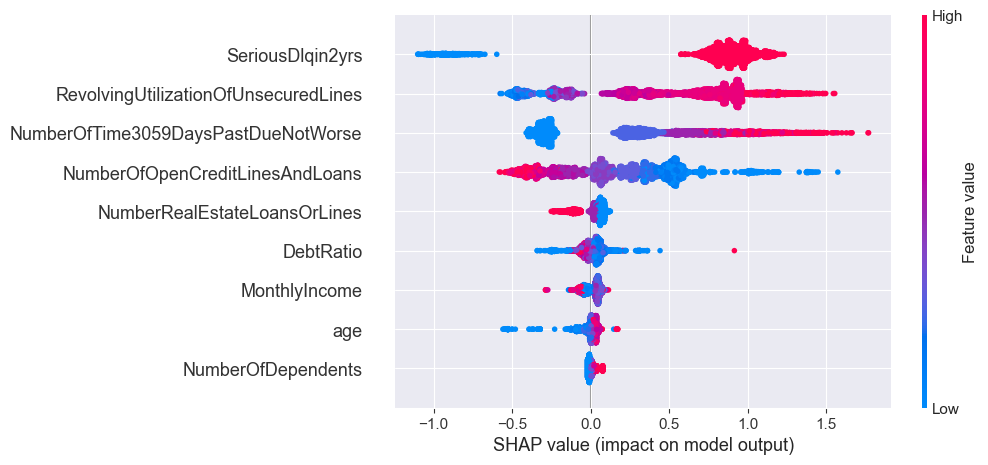

In [57]:
explainer = shap.Explainer(model)
shap_values = explainer(data.reset_index()[disc_data['inconf_error']==2][features])
shap.plots.beeswarm(shap_values)

In [64]:
disc_data.shape, data.shape

((768, 9), (768, 9))

In [62]:
#dfeat = ["length", "shell_weight"]
#dcat = [2, 1]
dfeat = ["SeriousDlqin2yrs"]
dcat = [1]

dfeatshap = ["SeriousDlqin2yrs"]
dcatshap = [1]
#[RevolvingUtilizationOfUnsecuredLines_2, NumberOfTime3059DaysPastDueNotWorse_2, DebtRatio_0, NumberOfOpenCreditLinesAndLoans_0, SeriousDlqin2yrs_1]MedInc_0, MedInc_2, Latitude_0, Longitude_0, Longitude_1]
dfeatbn = ["RevolvingUtilizationOfUnsecuredLines", "NumberOfTime3059DaysPastDueNotWorse", "DebtRatio", "NumberOfOpenCreditLinesAndLoans", "SeriousDlqin2yrs"]
dcatbn = [2, 2, 0, 0, 1]

bn = n
def bootstrap_sampling(dfeat, dcat, dfeatbn, dcatbn, dfeatshap, dcatshap, metrics_list, trials=1000, alpha=0, incl_random_removal=False):
    
    diffs = list()
    metrics_before, metrics_after = [list() for _ in range(len(metrics_list))], [list() for _ in range(len(metrics_list))]
    
    metrics_afterbn = [list() for _ in range(len(metrics_list))]
    
    metrics_shap = [list() for _ in range(len(metrics_list))]
    
    metrics_random = [list() for _ in range(len(metrics_list))]
    n_dropped = list()
    n_droppedbn = list()
    
    #пробуем побутсрапировать выборку, чтобы оценить значимость различий в ошибках регрессии
    for i in tqdm(range(trials)):
        indexes = np.random.choice(data.index, size=bn)
        bsample = data.loc[indexes]
        
        bsample_disc = pd.DataFrame(pipeline_data["transformer"].transform(data_errors.loc[indexes]), columns=data_errors.columns)
        
        mask = False
        maskbn = False
        maskshap = False
        for feat, cat in zip(dfeat, dcat):
            mask = mask | (bsample_disc[feat]==cat)
            
        for feat, cat in zip(dfeatbn, dcatbn):
            maskbn = maskbn | (bsample_disc[feat]==cat)
        
        for feat, cat in zip(dfeatshap, dcatshap):
            maskshap = maskshap | (bsample_disc[feat]==cat)
        
        X1, y1 = bsample[features], bsample[target]
        model1, model2, model2bn, model4 = copy(model), copy(model), copy(model), copy(model)
        model1.fit(X1, y1)
        y1_pred = model1.predict_proba(X1)[:, 1]
        indexes_to_drop = np.random.choice(bsample[mask].index, size=int(np.floor(bsample[mask].shape[0]*(1-alpha))), replace=False)
        
        indexes_to_drop_bn = np.random.choice(bsample[maskbn].index, size=int(np.floor(bsample[maskbn].shape[0]*(1-alpha))), replace=False)
        
        indexes_to_drop_shap = np.random.choice(bsample[maskshap].index, size=int(np.floor(bsample[maskshap].shape[0]*(1-alpha))), replace=False)
        
        new_bsample = bsample.drop(index=indexes_to_drop)
        new_bsamplebn = bsample.drop(index=indexes_to_drop_bn)
        new_bsample_shap = bsample.drop(index=indexes_to_drop_shap)
        
        X2, y2 = new_bsample[features], new_bsample[target]
        
        X2bn, y2bn = new_bsamplebn[features], new_bsamplebn[target]
        
        X4, y4 = new_bsample_shap[features], new_bsample_shap[target]
        
        model2.fit(X2, y2)
        model2bn.fit(X2bn, y2bn)
        
        model4.fit(X4, y4)
        
        y2_pred = model2.predict_proba(X2)[:, 1]
        y2_predbn = model2bn.predict_proba(X2bn)[:, 1]
        
        y4_pred = model4.predict_proba(X4)[:, 1]
        
        for k, metric in enumerate(metrics_list):
            metrics_before[k].append(metric(y1, y1_pred))
            metrics_after[k].append(metric(y2, y2_pred))
            metrics_afterbn[k].append(metric(y2bn, y2_predbn))
            metrics_shap[k].append(metric(y4, y4_pred))
        
        if incl_random_removal:
            random_bsample = bsample.sample(bsample.shape[0]-indexes_to_drop.shape[0])
            X3, y3 = random_bsample[features], random_bsample[target]
            model3 = copy(model)
            model3.fit(X3, y3)
            y3_pred = model3.predict_proba(X3)[:, 1]
            for k, metric in enumerate(metrics_list):
                metrics_random[k].append(metric(y3, y3_pred))
            
            
        #diffs.append(metrics_before[0][-1] - metrics_after[0][-1])
        n_dropped.append(indexes_to_drop.shape[0])
        n_droppedbn.append(indexes_to_drop_bn.shape[0])
    
    return ({'init': metrics_before,
                'yodo': metrics_after,
                'bn': metrics_afterbn,
                'shap': metrics_shap,
                'random': metrics_random if incl_random_removal else None},
                {'yodo': sum(n_dropped)/trials,
                 'bn': sum(n_droppedbn)/trials})

In [70]:
data.shape

(20634, 9)

In [63]:
np.random.seed(42)

metrics, mean_dropped = bootstrap_sampling(dfeat, dcat, 
                                           dfeatbn, dcatbn, 
                                            dfeatshap, dcatshap,
                                    [inconfidence_score, 
                                    log_loss,
                                    roc_auc_score], trials=100,alpha=0.3, incl_random_removal=True)

100%|██████████| 100/100 [08:57<00:00,  5.38s/it]


In [64]:
mean_dropped['yodo'], mean_dropped['yodo']/n

(5854.91, 0.3502997487136532)

In [65]:
mean_dropped['bn'], mean_dropped['bn']/n

(9994.47, 0.5979699652985521)

In [66]:
def plot_scores(metrics, labels, graph_label, k):
    for val, name in zip(metrics.values(), labels):
        sns.histplot(val[k], label=name, bins=25)
        
        
    #sns.histplot(metrics_after, label="After elimination", bins=25, color="orange")
    #sns.histplot(metrics_r, label="Random elimination", bins=25, color="green")
    #sns.histplot(metrics_s, label="SHAP elimination", bins=25, color="purple")
    #plt.axvline(x=np.mean(metrics_before), color="blue", linewidth=3)
    #plt.axvline(x=np.mean(metrics_after), color="orange", linewidth=3)
    #plt.axvline(x=np.mean(metrics_r), color="green", linewidth=3)
    #plt.axvline(x=np.mean(metrics_s[0]), color="purple", linewidth=3)
    plt.legend()
    plt.xlabel(graph_label)

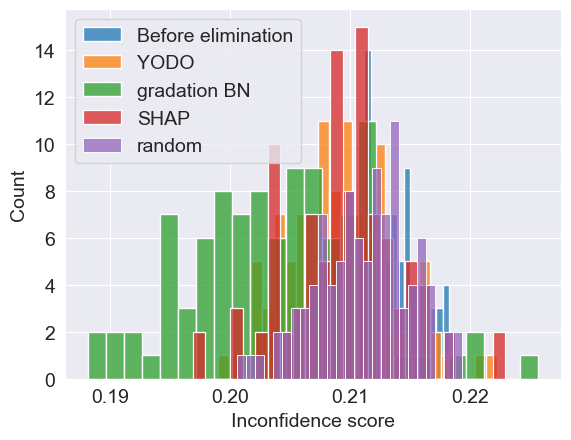

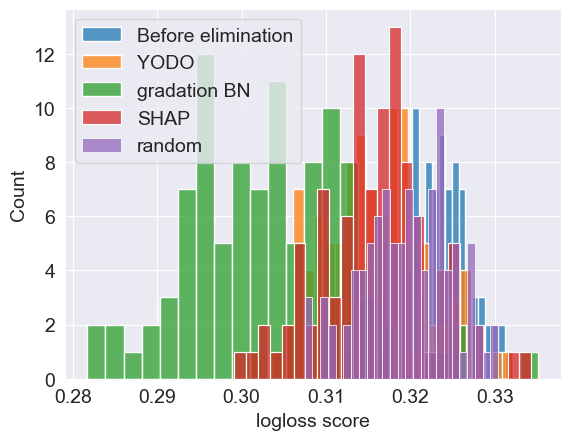

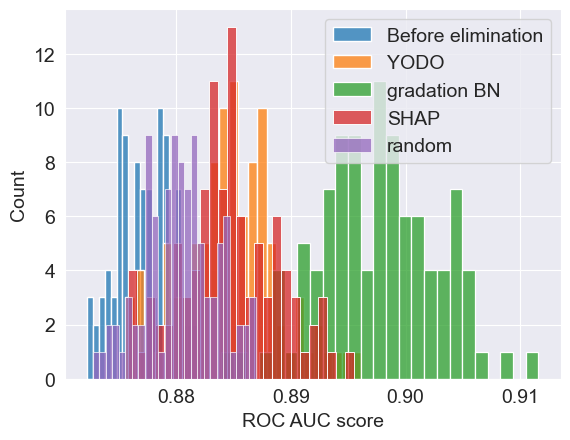

In [67]:
for k, label in enumerate(['Inconfidence score', 'logloss score', 'ROC AUC score']):
    plt.figure()
    plot_scores(metrics, ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ], label, k)

In [69]:
# Среднее улучшение скоров в процентах
improve = [-sum((a-b)/b for a, b in zip(y[0], metrics['init'][0]))/500*100 for y in metrics.values()]
improve

[-0.0,
 0.3273892385802817,
 0.8157879846355209,
 0.29339101749150165,
 0.13596665105681616]

In [ ]:
percentage_changes = {a: list() for a in metrics.keys()}

mean_differences = {a: list() for a in metrics.keys()}

mean_differences2 = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    metrics, mean_dropped = bootstrap_sampling(dfeat, dcat, 
                                           dfeatbn, dcatbn, 
                                            dfeatshap, dcatshap,
                                    [inconfidence_score, 
                                    log_loss,
                                    roc_auc_score], trials=500,alpha=a, incl_random_removal=True)
    if a == 0:
        print(_)
        
    for name in metrics.keys():
        x, y = np.array(metrics['init'][0]), np.array(metrics[name][0])
        mean_differences[name].append((x-y).mean())

        percentage_changes[name].append((-(y-x)/x).mean()*100)

for name in metrics.keys():
    mean_differences[name].append(0)
    percentage_changes[name].append(0)


100%|██████████| 500/500 [09:47<00:00,  1.17s/it]


[-0.0, 8.408690353135393, 9.78429861171597, 3.2177862491390146, 3.4801113773807457]


 75%|███████▍  | 373/500 [07:34<02:53,  1.36s/it]

In [43]:
percentage_changes = list()
percentage_changes_r = list()

percentage_changes2 = list()

mean_differences = list()
mean_differences_r = list()

mean_differences2 = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    metrics_before, metrics_after, diffs, mean_dropped, metrics_s, metrics_r = bootstrap_sampling(dfeat, dcat, 
                                                                                              ["S_weight", "diameter"],
                                                                                            [1, 1],
                                                                                              [inconfidence_score, 
                                                                                                 log_loss,
                                                                                                 roc_auc_score], trials=500,alpha=a, incl_random_removal=True)
    if a == 0:
        print(_)
    x, y, z, w = np.array(metrics_before[0]), np.array(metrics_after[0]), np.array(metrics_r[0]), np.array(metrics_s[0])
    mean_differences.append((x-y).mean())
    mean_differences_r.append((x-z).mean())
    mean_differences2.append((x-w).mean())
    percentage_changes.append(((y-x)/x).mean()*100)
    percentage_changes_r.append(((z-x)/x).mean()*100)
    percentage_changes2.append(((w-x)/x).mean()*100)
percentage_changes.append(0)
mean_differences.append(0)
percentage_changes2.append(0)
mean_differences2.append(0)
percentage_changes_r.append(0)
mean_differences_r.append(0)

100%|██████████| 500/500 [08:53<00:00,  1.07s/it]


(1452.954, 0.5125058201058201)


100%|██████████| 500/500 [07:23<00:00,  1.13it/s]


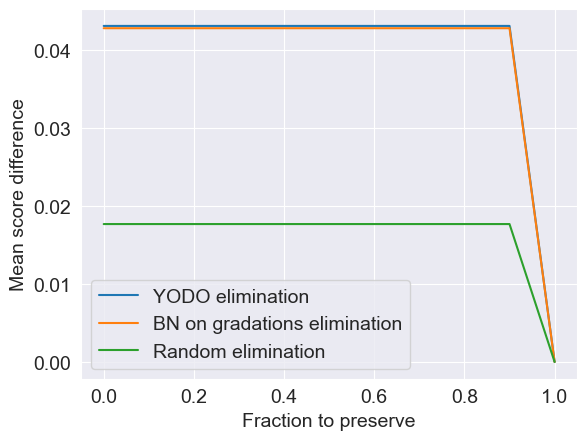

In [44]:
plt.plot(alphas, mean_differences, label='YODO elimination')
plt.plot(alphas, mean_differences2, label='BN on gradations elimination')
plt.plot(alphas, mean_differences_r, label='Random elimination')
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score difference")
plt.legend()

In [49]:
from scipy.stats import ttest_rel

In [39]:
ttest_rel(mses_before, mses_after)

NameError: name 'mses_before' is not defined

In [254]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=5.389314443207421, pvalue=1.0925112258579377e-07, df=499)

In [58]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,RevolvingUtilizationOfUnsecuredLines_0,RevolvingUtilizationOfUnsecuredLines_1,RevolvingUtilizationOfUnsecuredLines_2,age_0,age_1,age_2,NumberOfTime3059DaysPastDueNotWorse_1,NumberOfTime3059DaysPastDueNotWorse_2,DebtRatio_0,DebtRatio_1,...,NumberRealEstateLoansOrLines_1,NumberRealEstateLoansOrLines_2,NumberOfDependents_0,NumberOfDependents_1,NumberOfDependents_2,SeriousDlqin2yrs_0,SeriousDlqin2yrs_1,inconf_error_0,inconf_error_1,inconf_error_2
0,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,0,1,0,1,0,0
1,0,1,0,0,0,1,1,0,0,1,...,0,1,1,0,0,1,0,1,0,0
2,1,0,0,0,1,0,1,0,1,0,...,1,0,1,0,0,1,0,1,0,0
3,0,1,0,0,0,1,1,0,0,1,...,0,1,1,0,0,1,0,1,0,0
4,0,0,1,1,0,0,0,1,1,0,...,1,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16709,0,0,1,0,1,0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,1
16710,0,0,1,1,0,0,0,1,0,0,...,0,1,1,0,0,0,1,0,0,1
16711,0,0,1,1,0,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,1
16712,0,0,1,0,1,0,1,0,1,0,...,1,0,0,0,1,0,1,0,0,1


In [59]:
from itertools import product

In [60]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "inconf_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "inconf_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2024-01-24 23:32:23,464 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2024-01-24 23:32:23,465 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2024-01-24 23:32:23,466 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2024-01-24 23:32:23,467 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2024-01-24 23:32:23,468 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2024-01-24 23:32:23,470 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2024-01-24 23:32:23,471 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2024-01-24 23:32:23,471 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2024-01-24 23:32:23,472 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2024-01-24 23:32:23,473 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [61]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,NumberOfDependents_2,Discrete,disc,[],[]
1,age_2,Discrete,disc,[NumberOfDependents_2],[disc]
2,RevolvingUtilizationOfUnsecuredLines_1,Discrete,disc,[age_2],[disc]
3,DebtRatio_0,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines_1, age_2]","[disc, disc]"
4,RevolvingUtilizationOfUnsecuredLines_0,Discrete,disc,"[age_2, DebtRatio_0]","[disc, disc]"
5,SeriousDlqin2yrs_1,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines_0, Revol...","[disc, disc, disc]"
6,MonthlyIncome_1,Discrete,disc,[RevolvingUtilizationOfUnsecuredLines_0],[disc]
7,NumberOfTime3059DaysPastDueNotWorse_2,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines_0, Revol...","[disc, disc, disc, disc]"
8,SeriousDlqin2yrs_0,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines_0, Revol...","[disc, disc, disc, disc]"
9,MonthlyIncome_2,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines_0, Revol...","[disc, disc, disc]"



# k2score boosting: нет рекомендаций
# regression : [Tsurf_mean_0, pressure_2]

In [38]:
dfeat = ["S_weight", "diameter"]
dcat = [1, 1]
np.random.seed(42)
np.random.seed(42)
metrics_before, metrics_after, diffs, mean_dropped, metrics_s, metrics_r = bootstrap_sampling(dfeat, dcat, 
                                                                                              dfeatshap, dcatshap,
                                                                                              [inconfidence_score, 
                                                                                                 log_loss,
                                                                                                 roc_auc_score], trials=500,alpha=0.3, incl_random_removal=True)

100%|██████████| 500/500 [08:42<00:00,  1.05s/it]


In [40]:
mean_dropped, mean_dropped/n

(1452.954, 0.5125058201058201)

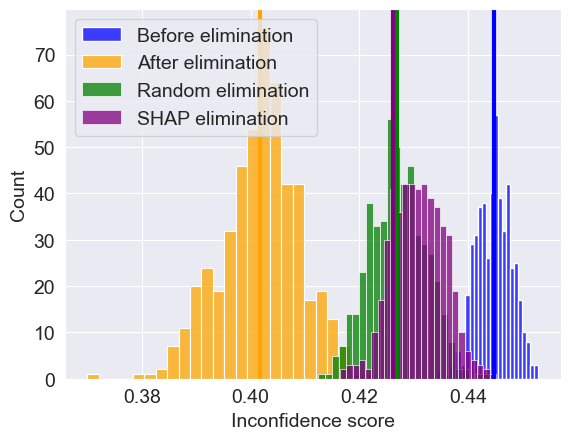

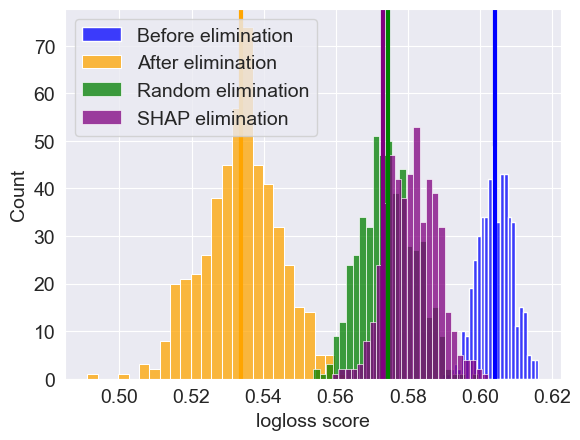

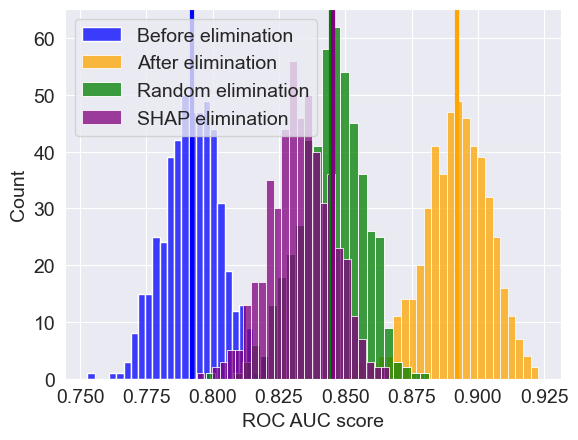

In [39]:
for k, label in enumerate(['Inconfidence score', 'logloss score', 'ROC AUC score']):
    plt.figure()
    plot_scores(metrics_before[k], metrics_after[k], metrics_r[k], metrics_s[k], label)

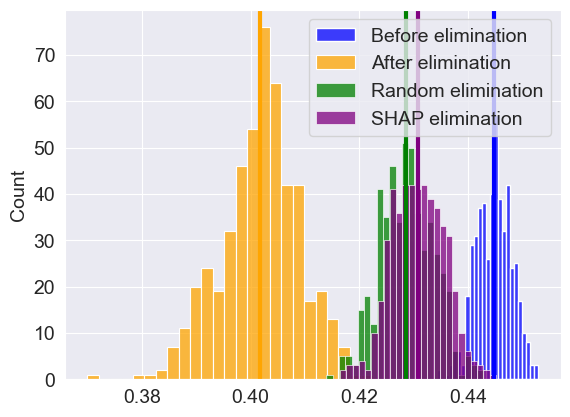

In [55]:
sns.histplot(metrics_before[0], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[0], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[0], label="Random elimination", bins=25, color="green")
sns.histplot(metrics_s[0], label="SHAP elimination", bins=25, color="purple")
plt.axvline(x=np.mean(metrics_before[0]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[0]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[0]), color="green", linewidth=3)
plt.axvline(x=np.mean(metrics_s[0]), color="purple", linewidth=3)
plt.legend()

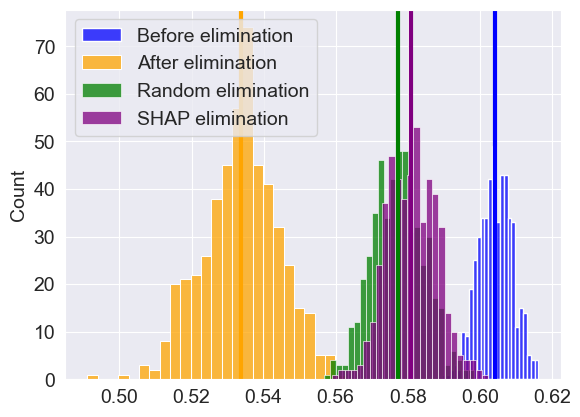

In [56]:
sns.histplot(metrics_before[1], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[1], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[1], label="Random elimination", bins=25, color="green")
sns.histplot(metrics_s[1], label="SHAP elimination", bins=25, color="purple")
plt.axvline(x=np.mean(metrics_before[1]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[1]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[1]), color="green", linewidth=3)
plt.axvline(x=np.mean(metrics_s[1]), color="purple", linewidth=3)
plt.legend()

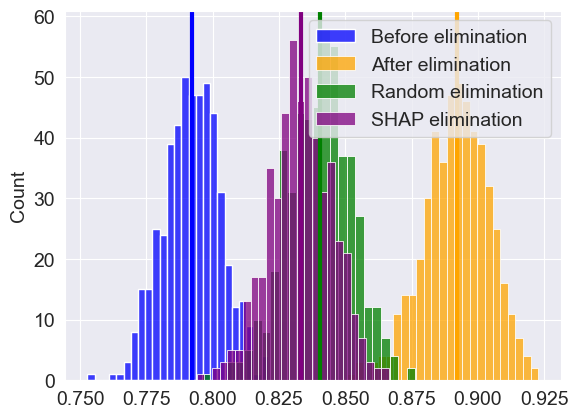

In [57]:
sns.histplot(metrics_before[2], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[2], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[2], label="Random elimination", bins=25, color="green")
sns.histplot(metrics_s[2], label="SHAP elimination", bins=25, color="purple")
plt.axvline(x=np.mean(metrics_before[2]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[2]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[2]), color="green", linewidth=3)
plt.axvline(x=np.mean(metrics_s[2]), color="purple", linewidth=3)
plt.legend()

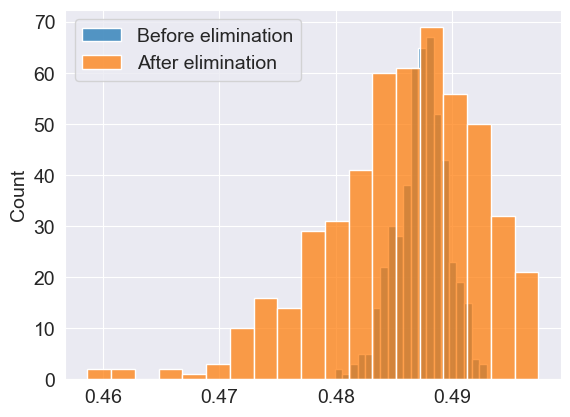

In [261]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [229]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=45.363657433495675, pvalue=3.570673536410195e-179, df=499)

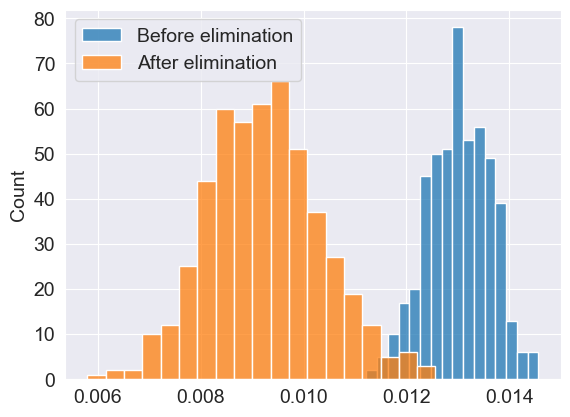

In [81]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [37]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=3.5513027688261474, pvalue=0.0005886470203057337)

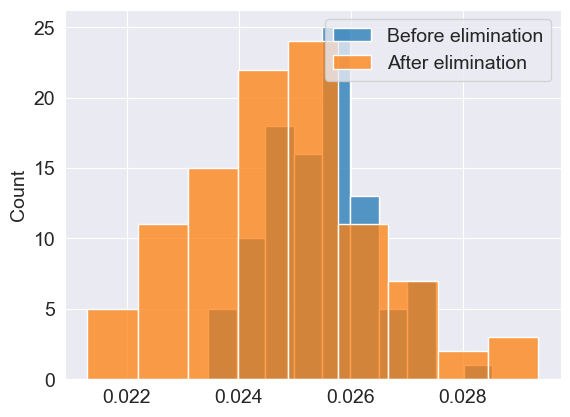

In [39]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [40]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=4.5674716964522615, pvalue=1.4238634976675129e-05)

In [41]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_onehot = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')

In [42]:
disc_data_onehot

,Tsurf_mean_0,Tsurf_mean_1,Tsurf_mean_2,Water_mean_0,Water_mean_1,Water_mean_2,Speed_mean_0,Speed_mean_1,Speed_mean_2,totalSnow_cm_0,...,humidity_2,precipMM_0,precipMM_1,precipMM_2,pressure_0,pressure_1,pressure_2,sq_error_0,sq_error_1,sq_error_2
0,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
1,0,0,1,0,1,0,1,0,0,0,...,1,1,0,0,1,0,0,0,1,0
2,0,1,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,1,0,0
3,0,0,1,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
4,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
996,0,1,0,1,0,0,0,0,1,1,...,0,1,0,0,0,1,0,1,0,0
997,0,0,1,1,0,0,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
998,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0


In [43]:
gbn = DiscreteBNGI(imagespath)

In [44]:
variables=["X1", "X2"]
#gbn.add_nodes(kresult["bn"].descriptor)
#grads = [feat+'_'+str(k) for feat in variables for k in range(n_states_map[feat])]
grads = [feat+'_'+str(k) for feat in variables for k in range(3)]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
#gbn.set_edges(grad_edges)
gbn.add_edges(data=disc_data_onehot, scoring_function=("K2", K2Score))

KeyError: 'Tsurf_mean_0'

In [ ]:
c=gbn.plot("regression.html")

In [ ]:
disc_data_errors, pipeline_data_errors = discretize(data_errors, variables=data_errors.columns.tolist(), icat=None, icont=[0, 1])

In [ ]:
disc_data_errors

In [ ]:
kresultresid = construct_by_kmeans(data_residuals, [], scoring=("K2", K2Score))

In [ ]:
c=kresultresid["bn"].plot2(imagespath, "residuals.html")